In [240]:
import numpy as np
import tensorflow.compat.v1 as tf

In [241]:
import deepxde as dde

In [242]:
# 결과 확인
import matplotlib.pyplot as plt

In [243]:
tf.disable_v2_behavior()

In [254]:
x_train = np.linspace(0, 10, 50).reshape(-1, 1)
y_train = np.sin(x_train).reshape(-1, 1)
y_target = np.cos(x_train).reshape(-1, 1)

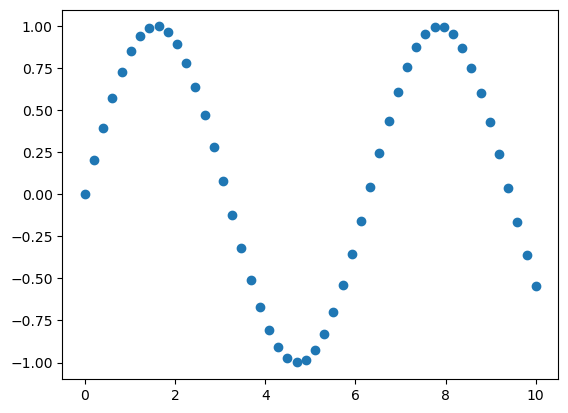

In [255]:
plt.scatter(x_train, y_train)

In [256]:
# Dummy PDE (학습에 사용되지 않음)
def pde(x, y):
    return tf.zeros_like(x)

geom = dde.geometry.Interval(-1, 1)
bc = dde.PointSetBC(y_train, y_target)

# num_domain은 0으로 설정하여 domain 포인트를 사용하지 않도록 합니다.
data = dde.data.PDE(geom, pde, bc, num_domain=0, num_boundary=len(x_train))

# Neural Operator 모델 정의 및 학습
layer_size = [1] + [150] + [250] + [100] + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, loss_weights=[0, 1])

losshistory, train_state = model.train(epochs=30000, batch_size = 250)


Compiling model...
Building feed-forward neural network...
'build' took 0.037710 s



c:\Users\user\Anaconda3\envs\gpu\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.624687 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 5.32e-01]    [0.00e+00, 5.32e-01]    []  
1000      [0.00e+00, 5.07e-01]    [0.00e+00, 5.07e-01]    []  
2000      [0.00e+00, 4.11e-01]    [0.00e+00, 4.11e-01]    []  
3000      [0.00e+00, 2.62e-01]    [0.00e+00, 2.62e-01]    []  
4000      [0.00e+00, 2.12e-01]    [0.00e+00, 2.12e-01]    []  
5000      [0.00e+00, 1.30e-01]    [0.00e+00, 1.30e-01]    []  
6000      [0.00e+00, 1.16e-01]    [0.00e+00, 1.16e-01]    []  
7000      [0.00e+00, 9.74e-02]    [0.00e+00, 9.74e-02]    []  
8000      [0.00e+00, 7.87e-02]    [0.00e+00, 7.87e-02]    []  
9000      [0.00e+00, 6.80e-02]    [0.00e+00, 6.80e-02]    []  
10000     [0.00e+00, 5.45e-02]    [0.00e+00, 5.45e-02]    []  
11000     [0.00e+00, 8.64e-02]    [0.00e+00, 8.64e-02]    []  
12000     [0.00e+00, 4.64e-02]    [0.00e+00, 4.64e-02]    []  
13000     [0.00e+00, 6.03e-02]    [0.00e+00, 6.03e-02]    []  
14

In [257]:
bc.values

<tf.Tensor 'Const_273:0' shape=(50, 1) dtype=float32>

In [258]:
y_pred = model.predict(y_train)

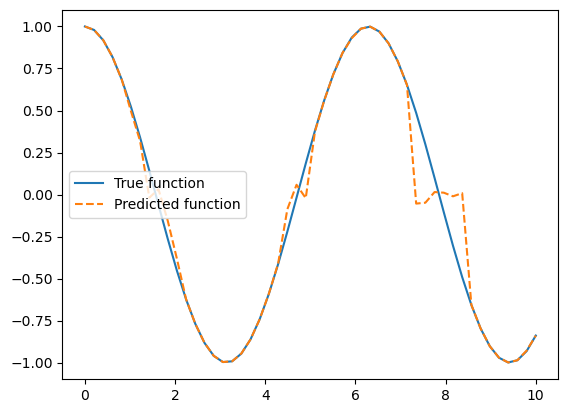

In [259]:
plt.plot(x_train, y_target, label="True function")
plt.plot(x_train, y_pred, '--', label="Predicted function")
plt.legend()
plt.show()

In [283]:
x_train_2 = np.linspace(0, 15, 100).reshape(-1, 1)
y_train_2 = np.sin(x_train_2).reshape(-1, 1)
y_target_2 = np.cos(x_train_2).reshape(-1, 1)

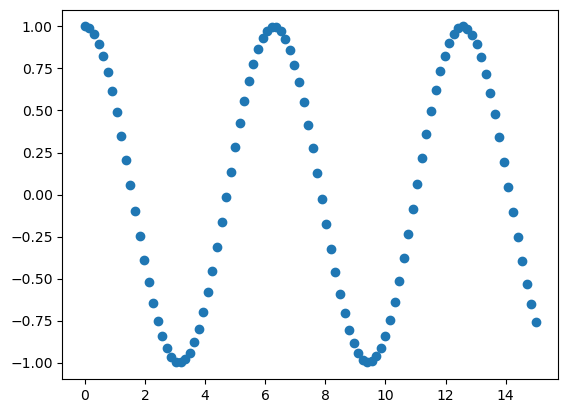

In [284]:
plt.scatter(x_train_2, y_target_2)

In [291]:
# Dummy PDE (학습에 사용되지 않음)
def pde(x, y):
    return tf.zeros_like(x)

geom_2 = dde.geometry.Interval(-1, 1)
bc_2 = dde.PointSetBC(y_train_2, y_target_2)

# num_domain은 0으로 설정하여 domain 포인트를 사용하지 않도록 합니다.
data_2 = dde.data.PDE(geom_2, pde, bc_2, num_domain=0, num_boundary=len(x_train_2))

# Neural Operator 모델 정의 및 학습
layer_size_2 = [1] + [200] + [250] + [100] + [1]
activation_2 = "tanh"
initializer_2 = "Glorot uniform"
net_2 = dde.maps.FNN(layer_size_2, activation_2, initializer_2)

model_2 = dde.Model(data_2, net_2)
model_2.compile("adam", lr=0.0005, loss_weights=[0, 1])

losshistory_2, train_state_2 = model_2.train(epochs=50000, batch_size = 250)


Compiling model...
Building feed-forward neural network...
'build' took 0.039201 s

'compile' took 0.720246 s

Training model...

Step      Train loss              Test loss               Test metric
0         [0.00e+00, 4.87e-01]    [0.00e+00, 4.87e-01]    []  
1000      [0.00e+00, 4.79e-01]    [0.00e+00, 4.79e-01]    []  
2000      [0.00e+00, 4.79e-01]    [0.00e+00, 4.79e-01]    []  
3000      [0.00e+00, 4.79e-01]    [0.00e+00, 4.79e-01]    []  
4000      [0.00e+00, 4.78e-01]    [0.00e+00, 4.78e-01]    []  
5000      [0.00e+00, 4.78e-01]    [0.00e+00, 4.78e-01]    []  
6000      [0.00e+00, 4.75e-01]    [0.00e+00, 4.75e-01]    []  
7000      [0.00e+00, 4.58e-01]    [0.00e+00, 4.58e-01]    []  
8000      [0.00e+00, 3.99e-01]    [0.00e+00, 3.99e-01]    []  
9000      [0.00e+00, 2.83e-01]    [0.00e+00, 2.83e-01]    []  
10000     [0.00e+00, 2.14e-01]    [0.00e+00, 2.14e-01]    []  
11000     [0.00e+00, 1.89e-01]    [0.00e+00, 1.89e-01]    []  
12000     [0.00e+00, 1.53e-01]    [0.00e+00,

In [292]:
y_pred_2 = model_2.predict(y_train)

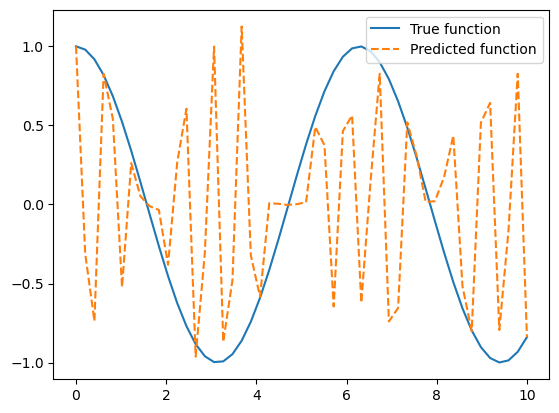

In [293]:
plt.plot(x_train, y_target, label="True function")
plt.plot(x_train, y_pred_2, '--', label="Predicted function")
plt.legend()
plt.show()

In [312]:
nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(150, activation='tanh'),
    tf.keras.layers.Dense(1)
])

nn.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [313]:
nn.fit(y_train, y_target, epochs=5000, batch_size=250, verbose=0)

In [314]:
result = nn.predict(y_train)

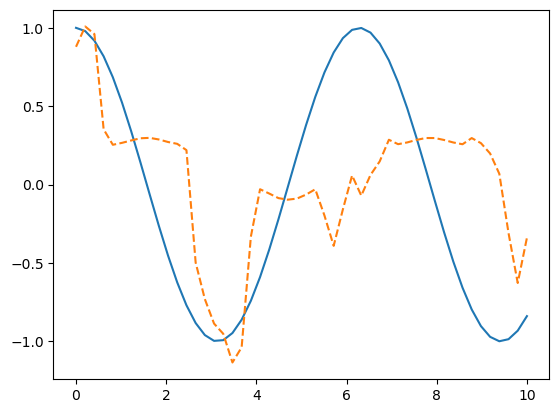

In [315]:
plt.plot(x_train, y_target, label="True function")
plt.plot(x_train, result, '--', label="Predicted function")

In [316]:
nn.fit(y_train_2, y_target_2, epochs=5000, batch_size=250, verbose=0)

In [317]:
result_2 = nn.predict(y_train_2)

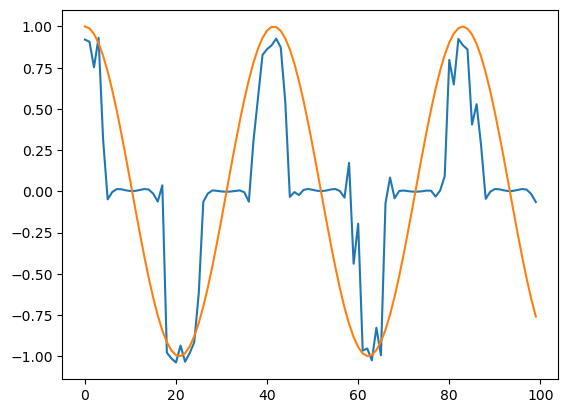

In [318]:
plt.plot(result_2)
plt.plot(y_target_2)